In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import re
fe = fm.FontEntry(fname=r'font/NanumGothic.otf', name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm 
from tqdm.auto import tqdm
import pickle


# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore') #import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit

# 모델링
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.metrics import r2_score

import eli5
from eli5.sklearn import PermutationImportance


# 데이터셋 로드 및 정제
import joblib
import gdown

# 컬럼 화면 설정
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 50)

In [2]:
# pip install gdown

## 타임시리즈 사용을 위해서 계약년월일 열 합치기
- 정리된 데이터 있으면 바꿔도 됨

In [3]:
data_path = '../data/'

data = pd.read_csv(f'{data_path}240717_ing_not_null_3.csv')

In [4]:
df = data.copy()

In [5]:
df.head(1)

,계약_년도,계약_월,계약_일,건축년도,시,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수,target,is_test
0,2017,12,8,1987,서울특별시,강남구,개포동,658-1,언주로 3,개포6차우성,3,79.97,20,250,0,0,262,8,270,0,0,0,0,0,0,0,0,270,127.056859,37.476276,서울포이초등학교,0.385832,구룡,분당선,1187.672025,17.81508,매봉,3호선,1483.43809,22.251571,도곡,3호선,1633.265245,24.498979,0,0,0,1,124000.0,0


In [6]:
# df['계약_년월일'] = df['계약_년도'].astype(str) + df['계약_월'].astype(str) + df['계약_일'].astype(str)
# 계약_월과 계약_일이 한 자리 수인 경우 앞에 0을 추가하여 두 자리로 만듭니다.
df['계약_월'] = df['계약_월'].astype(str).str.zfill(2)
df['계약_일'] = df['계약_일'].astype(str).str.zfill(2)

# 계약_년월일 열을 생성합니다.
df['계약_년월일'] = df['계약_년도'].astype(str) + df['계약_월'] + df['계약_일']

# 계약_년월일 열을 datetime 형식으로 변환할 수 있습니다.
df['계약_년월일'] = df['계약_년월일'].astype('int')
#df['계약_년월일'] = pd.to_datetime(df['계약_년월일'], format='%Y%m%d')

In [7]:
df.drop(columns=['계약_년도','계약_월', '계약_일','시'], inplace=True)

In [8]:
df['계약_년월일'].dtype

dtype('int32')

In [9]:
df_1 = df[df['is_test'] == 0].copy()
df_2 = df[df['is_test'] == 1].copy()

In [10]:
df_1.sort_values('계약_년월일', inplace=True)

In [11]:
df = pd.concat([df_1, df_2], axis=0).copy()

In [12]:
date = df[['계약_년월일']]

In [13]:
date

,계약_년월일
1099430,20070101
1103737,20070101
1106826,20070101
1079315,20070101
1116446,20070101
...,...
1128089,20230719
1128090,20230725
1128091,20230827
1128092,20230902


In [14]:
df_columns = df.iloc[:,:-1].columns

In [15]:
date[df_columns] = df.iloc[:,:-1].copy()

In [16]:
date

,계약_년월일,건축년도,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수,target,is_test
1099430,20070101,1992,동대문구,답십리동,42,답십리로 210-30,동답한신,7,59.22,460,84,56,0,204,0,0,0,0,4,600,0,0,0,0,600,127.062600,37.570831,서울동답초등학교,0.146751,장한평,5호선,1059.335627,15.890034,답십리,5호선,983.317669,14.749765,용답,2호선,1431.392024,21.470880,0,0,1,1,18400.0,0
1103737,20070101,2004,서대문구,북가좌동,325-18,증가로29길 30-18,충우팰리스1,3,84.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,126.911028,37.582160,서울북가좌초등학교,0.619432,증산(명지대앞),6호선,226.402943,3.396044,새절(신사),6호선,1025.378314,15.380675,디지털미디어시티,6호선,1083.521918,16.252829,1,0,0,5,24000.0,0
1106826,20070101,2000,성북구,정릉동,1020,북악산로 813,정릉우성,10,84.99,187,599,37,0,708,0,0,0,0,0,0,0,0,0,0,823,127.015807,37.601025,서울정덕초등학교,0.374289,정릉,우이신설선,316.280546,4.744208,성신여대입구(돈암),4호선,937.183368,14.057751,성신여대입구(돈암),우이신설선,953.688548,14.305328,1,0,3,0,31500.0,0
1079315,20070101,2006,강동구,길동,456-2,진황도로 100,하이브,8,59.97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,127.137322,37.535587,서울천동초등학교,0.605317,길동,5호선,341.353786,5.120307,강동,5호선,427.552670,6.413290,둔촌동,5호선,872.366995,13.085505,0,2,1,4,21100.0,0
1116446,20070101,1987,중랑구,면목동,193-1,중랑천로 20,면목한신,5,45.44,1012,350,0,0,524,0,0,0,0,0,0,0,0,0,0,1362,127.075478,37.587509,서울중랑초등학교,0.239482,중랑,중앙선,825.625078,12.384376,면목,7호선,1066.203694,15.993055,상봉(시외버스터미널),7호선,1272.192782,19.082892,0,0,1,3,11500.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,20230719,2014,중랑구,신내동,816,신내역로1길 85,신내우디안1단지,13,84.65,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,서울새솔초등학교,0.437157,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2,NaN,1
1128090,20230725,2014,중랑구,신내동,816,신내역로1길 85,신내우디안1단지,12,84.62,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,서울새솔초등학교,0.437157,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2,NaN,1
1128091,20230827,2014,중랑구,신내동,816,신내역로1길 85,신내우디안1단지,12,101.65,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,서울새솔초등학교,0.437157,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2,NaN,1
1128092,20230902,2014,중랑구,신내동,816,신내역로1길 85,신내우디안1단지,18,84.94,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,서울새솔초등학교,0.437157,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2,NaN,1


##### 데이터 샘플링하는 부분

In [17]:
# # 모델 구현을 위해 샘플링

# sample_1 = date[date['is_test']==0].copy()
# sample_1.drop(columns=['is_test'], inplace=True)
# sample_1.sort_values('계약_년월일', inplace=True)
# sample = sample_1[1006939:].copy()
# sample.reset_index(inplace=True, drop=True)
# sample

In [18]:
# sample.reset_index(inplace=True, drop=True)
# X = sample.drop(columns=['target'])
# y = sample['target']

In [19]:
# y

In [20]:
# sample.drop(columns=['시'], inplace=True)

##### 여기부터는 dataset 
- 샘플용으로 써도 됨

In [21]:
date.head(1) # 1128094 rows × 48 columns

,계약_년월일,건축년도,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수,target,is_test
1099430,20070101,1992,동대문구,답십리동,42,답십리로 210-30,동답한신,7,59.22,460,84,56,0,204,0,0,0,0,4,600,0,0,0,0,600,127.0626,37.570831,서울동답초등학교,0.146751,장한평,5호선,1059.335627,15.890034,답십리,5호선,983.317669,14.749765,용답,2호선,1431.392024,21.47088,0,0,1,1,18400.0,0


In [22]:
date.reset_index(inplace=True, drop=True)

In [23]:
sample = date.copy()

In [24]:
sample

,계약_년월일,건축년도,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수,target,is_test
0,20070101,1992,동대문구,답십리동,42,답십리로 210-30,동답한신,7,59.22,460,84,56,0,204,0,0,0,0,4,600,0,0,0,0,600,127.062600,37.570831,서울동답초등학교,0.146751,장한평,5호선,1059.335627,15.890034,답십리,5호선,983.317669,14.749765,용답,2호선,1431.392024,21.470880,0,0,1,1,18400.0,0
1,20070101,2004,서대문구,북가좌동,325-18,증가로29길 30-18,충우팰리스1,3,84.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,126.911028,37.582160,서울북가좌초등학교,0.619432,증산(명지대앞),6호선,226.402943,3.396044,새절(신사),6호선,1025.378314,15.380675,디지털미디어시티,6호선,1083.521918,16.252829,1,0,0,5,24000.0,0
2,20070101,2000,성북구,정릉동,1020,북악산로 813,정릉우성,10,84.99,187,599,37,0,708,0,0,0,0,0,0,0,0,0,0,823,127.015807,37.601025,서울정덕초등학교,0.374289,정릉,우이신설선,316.280546,4.744208,성신여대입구(돈암),4호선,937.183368,14.057751,성신여대입구(돈암),우이신설선,953.688548,14.305328,1,0,3,0,31500.0,0
3,20070101,2006,강동구,길동,456-2,진황도로 100,하이브,8,59.97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,127.137322,37.535587,서울천동초등학교,0.605317,길동,5호선,341.353786,5.120307,강동,5호선,427.552670,6.413290,둔촌동,5호선,872.366995,13.085505,0,2,1,4,21100.0,0
4,20070101,1987,중랑구,면목동,193-1,중랑천로 20,면목한신,5,45.44,1012,350,0,0,524,0,0,0,0,0,0,0,0,0,0,1362,127.075478,37.587509,서울중랑초등학교,0.239482,중랑,중앙선,825.625078,12.384376,면목,7호선,1066.203694,15.993055,상봉(시외버스터미널),7호선,1272.192782,19.082892,0,0,1,3,11500.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,20230719,2014,중랑구,신내동,816,신내역로1길 85,신내우디안1단지,13,84.65,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,서울새솔초등학교,0.437157,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2,NaN,1
1128090,20230725,2014,중랑구,신내동,816,신내역로1길 85,신내우디안1단지,12,84.62,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,서울새솔초등학교,0.437157,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2,NaN,1
1128091,20230827,2014,중랑구,신내동,816,신내역로1길 85,신내우디안1단지,12,101.65,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,서울새솔초등학교,0.437157,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2,NaN,1
1128092,20230902,2014,중랑구,신내동,816,신내역로1길 85,신내우디안1단지,18,84.94,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,서울새솔초등학교,0.437157,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2,NaN,1


In [25]:
y_df = sample[['target', 'is_test']].copy()
y_df

,target,is_test
0,18400.0,0
1,24000.0,0
2,31500.0,0
3,21100.0,0
4,11500.0,0
...,...,...
1128089,NaN,1
1128090,NaN,1
1128091,NaN,1
1128092,NaN,1


In [26]:
y = y_df.loc[y_df['is_test'] == 0, 'target'].copy()

In [27]:
sample.drop(columns=['target'], inplace=True)

In [28]:
sample.head(1) 

,계약_년월일,건축년도,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수,is_test
0,20070101,1992,동대문구,답십리동,42,답십리로 210-30,동답한신,7,59.22,460,84,56,0,204,0,0,0,0,4,600,0,0,0,0,600,127.0626,37.570831,서울동답초등학교,0.146751,장한평,5호선,1059.335627,15.890034,답십리,5호선,983.317669,14.749765,용답,2호선,1431.392024,21.47088,0,0,1,1,0


- 맨앞, 맨뒤 열 뺴고 스케일하기!!

In [29]:
sample.iloc[:,1:-1]

,건축년도,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수
0,1992,동대문구,답십리동,42,답십리로 210-30,동답한신,7,59.22,460,84,56,0,204,0,0,0,0,4,600,0,0,0,0,600,127.062600,37.570831,서울동답초등학교,0.146751,장한평,5호선,1059.335627,15.890034,답십리,5호선,983.317669,14.749765,용답,2호선,1431.392024,21.470880,0,0,1,1
1,2004,서대문구,북가좌동,325-18,증가로29길 30-18,충우팰리스1,3,84.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,126.911028,37.582160,서울북가좌초등학교,0.619432,증산(명지대앞),6호선,226.402943,3.396044,새절(신사),6호선,1025.378314,15.380675,디지털미디어시티,6호선,1083.521918,16.252829,1,0,0,5
2,2000,성북구,정릉동,1020,북악산로 813,정릉우성,10,84.99,187,599,37,0,708,0,0,0,0,0,0,0,0,0,0,823,127.015807,37.601025,서울정덕초등학교,0.374289,정릉,우이신설선,316.280546,4.744208,성신여대입구(돈암),4호선,937.183368,14.057751,성신여대입구(돈암),우이신설선,953.688548,14.305328,1,0,3,0
3,2006,강동구,길동,456-2,진황도로 100,하이브,8,59.97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,127.137322,37.535587,서울천동초등학교,0.605317,길동,5호선,341.353786,5.120307,강동,5호선,427.552670,6.413290,둔촌동,5호선,872.366995,13.085505,0,2,1,4
4,1987,중랑구,면목동,193-1,중랑천로 20,면목한신,5,45.44,1012,350,0,0,524,0,0,0,0,0,0,0,0,0,0,1362,127.075478,37.587509,서울중랑초등학교,0.239482,중랑,중앙선,825.625078,12.384376,면목,7호선,1066.203694,15.993055,상봉(시외버스터미널),7호선,1272.192782,19.082892,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,2014,중랑구,신내동,816,신내역로1길 85,신내우디안1단지,13,84.65,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,서울새솔초등학교,0.437157,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2
1128090,2014,중랑구,신내동,816,신내역로1길 85,신내우디안1단지,12,84.62,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,서울새솔초등학교,0.437157,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2
1128091,2014,중랑구,신내동,816,신내역로1길 85,신내우디안1단지,12,101.65,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,서울새솔초등학교,0.437157,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2
1128092,2014,중랑구,신내동,816,신내역로1길 85,신내우디안1단지,18,84.94,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,서울새솔초등학교,0.437157,신내,경춘선,558.051187,8.370768,신내,6호선,582.393162,8.735897,양원,중앙선,1185.393002,17.780895,0,2,0,2


In [30]:
object_col = sample.iloc[:,1:-1].select_dtypes(include=['object']).columns
object_col


Index(['구', '동', '번지', '도로명', '건물명', '최단거리초등학교명', '1번째_가까운_역_이름',
       '1번째_가까운_역_호선', '2번째_가까운_역_이름', '2번째_가까운_역_호선', '3번째_가까운_역_이름',
       '3번째_가까운_역_호선'],
      dtype='object')

In [31]:
num_col = sample.iloc[:,1:-1].select_dtypes(include=['int64', 'float64']).columns
num_col


Index(['건축년도', '층', '전용면적(㎡)', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', '주차대수', '5층 동수', '5층 세대수', '6~10층 동수',
       '6~10층 세대수', '11~15층 동수', '11~15층 세대수', '16~20층 동수', '16~20층 세대수',
       '21층이상 동수', '21층이상 세대수', '세대수_수정', '좌표X_jm', '좌표Y_jm', '최단거리초등학교Km',
       '1번째_가까운_역_거리', '1번째_가까운_역_도보시간', '2번째_가까운_역_거리', '2번째_가까운_역_도보시간',
       '3번째_가까운_역_거리', '3번째_가까운_역_도보시간', '5분이하_역_개수', '5분초과_10분이하_역_개수',
       '10분초과_15분이하_역_개수', '15분초과_20분이하_역_개수'],
      dtype='object')

In [32]:
# LabelEncoder 생성
label_encoder = LabelEncoder()

# object dtype을 가진 모든 열에 대해 레이블 인코딩 적용
for col in sample.select_dtypes(include=['object']).columns:
    sample[col] = label_encoder.fit_transform(sample[col])

In [33]:
df_scale = sample.copy()

In [34]:
df_scale

,계약_년월일,건축년도,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수,is_test
0,20070101,1992,10,48,3364,1887,1364,7,59.22,460,84,56,0,204,0,0,0,0,4,600,0,0,0,0,600,127.062600,37.570831,149,0.146751,261,4,1059.335627,15.890034,67,4,983.317669,14.749765,246,1,1431.392024,21.470880,0,0,1,1,0
1,20070101,2004,13,126,2671,7895,5522,3,84.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,126.911028,37.582160,225,0.619432,274,5,226.402943,3.396044,150,5,1025.378314,15.380675,96,5,1083.521918,16.252829,1,0,0,5,0
2,20070101,2000,16,268,167,4238,5014,10,84.99,187,599,37,0,708,0,0,0,0,0,0,0,0,0,0,823,127.015807,37.601025,493,0.374289,262,21,316.280546,4.744208,171,3,937.183368,14.057751,176,23,953.688548,14.305328,1,0,3,0,0
3,20070101,2006,1,30,3641,8016,5910,8,59.97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,127.137322,37.535587,525,0.605317,46,4,341.353786,5.120307,8,4,427.552670,6.413290,93,4,872.366995,13.085505,0,2,1,4,0
4,20070101,1987,24,94,1749,7806,2057,5,45.44,1012,350,0,0,524,0,0,0,0,0,0,0,0,0,0,1362,127.075478,37.587509,505,0.239482,270,23,825.625078,12.384376,106,6,1066.203694,15.993055,150,6,1272.192782,19.082892,0,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,20230719,2014,24,174,5801,5550,3690,13,84.65,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,254,0.437157,184,14,558.051187,8.370768,186,5,582.393162,8.735897,220,25,1185.393002,17.780895,0,2,0,2,1
1128090,20230725,2014,24,174,5801,5550,3690,12,84.62,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,254,0.437157,184,14,558.051187,8.370768,186,5,582.393162,8.735897,220,25,1185.393002,17.780895,0,2,0,2,1
1128091,20230827,2014,24,174,5801,5550,3690,12,101.65,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,254,0.437157,184,14,558.051187,8.370768,186,5,582.393162,8.735897,220,25,1185.393002,17.780895,0,2,0,2,1
1128092,20230902,2014,24,174,5801,5550,3690,18,84.94,808,504,90,0,1568,0,0,0,0,4,250,4,392,8,760,1402,127.106467,37.617195,254,0.437157,184,14,558.051187,8.370768,186,5,582.393162,8.735897,220,25,1185.393002,17.780895,0,2,0,2,1


In [35]:
# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# Min-Max 스케일링 적용할 열 선택
# columns_to_scale = df.columns  # 모든 열을 스케일링할 경우

# 선택한 열에 Min-Max 스케일링 적용
df_scale.iloc[:,1:-1] = scaler.fit_transform(df_scale.iloc[:,1:-1])

print("\nDataFrame after Min-Max Scaling:")
print(df_scale)


DataFrame after Min-Max Scaling:
           계약_년월일      건축년도         구         동        번지       도로명       건물명  \
0        20070101  0.500000  0.416667  0.142857  0.511479  0.204221  0.207232   
1        20070101  0.693548  0.541667  0.375000  0.406112  0.854437  0.838955   
2        20070101  0.629032  0.666667  0.797619  0.025392  0.458658  0.761775   
3        20070101  0.725806  0.041667  0.089286  0.553596  0.867532  0.897903   
4        20070101  0.419355  1.000000  0.279762  0.265927  0.844805  0.312519   
...           ...       ...       ...       ...       ...       ...       ...   
1128089  20230719  0.854839  1.000000  0.517857  0.882013  0.600649  0.560620   
1128090  20230725  0.854839  1.000000  0.517857  0.882013  0.600649  0.560620   
1128091  20230827  0.854839  1.000000  0.517857  0.882013  0.600649  0.560620   
1128092  20230902  0.854839  1.000000  0.517857  0.882013  0.600649  0.560620   
1128093  20230904  0.854839  1.000000  0.517857  0.882013  0.600649  0.5606

In [36]:
df_scale

,계약_년월일,건축년도,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수,is_test
0,20070101,0.500000,0.416667,0.142857,0.511479,0.204221,0.207232,0.150685,0.118755,0.092462,0.016368,0.020528,0,0.016865,0.0,0.0,0.0,0.0,0.071429,0.133511,0.000000,0.00000,0.000000,0.000000,0.062697,0.684556,0.538601,0.250420,0.070227,0.847403,0.173913,0.281852,0.281852,0.215434,0.16,0.244992,0.244992,0.776025,0.04,0.327587,0.327587,0.0,0.00,0.111111,0.0625,0
1,20070101,0.693548,0.541667,0.375000,0.406112,0.854437,0.838955,0.095890,0.180690,0.000000,0.000000,0.000000,0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.001052,0.280034,0.583343,0.378151,0.340875,0.889610,0.217391,0.056241,0.056241,0.482315,0.20,0.255964,0.255964,0.302839,0.20,0.244853,0.244853,0.2,0.00,0.000000,0.3125,0
2,20070101,0.629032,0.666667,0.797619,0.025392,0.458658,0.761775,0.191781,0.180956,0.037588,0.116719,0.013563,0,0.058532,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.086156,0.559673,0.657849,0.828571,0.200511,0.850649,0.913043,0.080585,0.080585,0.549839,0.12,0.232957,0.232957,0.555205,0.92,0.213975,0.213975,0.2,0.00,0.333333,0.0000,0
3,20070101,0.725806,0.041667,0.089286,0.553596,0.867532,0.897903,0.164384,0.120565,0.000000,0.000000,0.000000,0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.007259,0.883977,0.399411,0.882353,0.332793,0.149351,0.173913,0.087377,0.087377,0.025723,0.16,0.100013,0.100013,0.293375,0.16,0.194635,0.194635,0.0,0.25,0.111111,0.2500,0
4,20070101,0.419355,1.000000,0.279762,0.265927,0.844805,0.312519,0.123288,0.085494,0.203417,0.068200,0.000000,0,0.043320,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.142857,0.718926,0.604469,0.848739,0.123323,0.876623,1.000000,0.218548,0.218548,0.340836,0.24,0.266614,0.266614,0.473186,0.24,0.289725,0.289725,0.0,0.00,0.111111,0.1875,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,20230719,0.854839,1.000000,0.517857,0.882013,0.600649,0.560620,0.232877,0.180135,0.162412,0.098207,0.032991,0,0.129630,0.0,0.0,0.0,0.0,0.071429,0.055630,0.095238,0.08244,0.123077,0.113365,0.147065,0.801631,0.721710,0.426891,0.236508,0.597403,0.608696,0.146072,0.146072,0.598071,0.20,0.140406,0.140406,0.694006,1.00,0.269081,0.269081,0.0,0.25,0.000000,0.1250,1
1128090,20230725,0.854839,1.000000,0.517857,0.882013,0.600649,0.560620,0.219178,0.180063,0.162412,0.098207,0.032991,0,0.129630,0.0,0.0,0.0,0.0,0.071429,0.055630,0.095238,0.08244,0.123077,0.113365,0.147065,0.801631,0.721710,0.426891,0.236508,0.597403,0.608696,0.146072,0.146072,0.598071,0.20,0.140406,0.140406,0.694006,1.00,0.269081,0.269081,0.0,0.25,0.000000,0.1250,1
1128091,20230827,0.854839,1.000000,0.517857,0.882013,0.600649,0.560620,0.219178,0.221168,0.162412,0.098207,0.032991,0,0.129630,0.0,0.0,0.0,0.0,0.071429,0.055630,0.095238,0.08244,0.123077,0.113365,0.147065,0.801631,0.721710,0.426891,0.236508,0.597403,0.608696,0.146072,0.146072,0.598071,0.20,0.140406,0.140406,0.694006,1.00,0.269081,0.269081,0.0,0.25,0.000000,0.1250,1
1128092,20230902,0.854839,1.000000,0.517857,0.882013,0.600649,0.560620,0.301370,0.180835,0.162412,0.098207,0.032991,0,0.129630,0.0,0.0,0.0,0.0,0.071429,0.055630,0.095238,0.08244,0.123077,0.113365,0.147065,0.801631,0.721710,0.426891,0.236508,0.597403,0.608696,0.146072,0.146072,0.598071,0.20,0.140406,0.140406,0.694006,1.00,0.269081,0.269081,0.0,0.25,0.000000,0.1250,1


In [37]:
X_df = df_scale.copy()
Y = y.copy()

In [38]:
X = X_df[X_df['is_test'] == 0].drop(columns=['is_test']).copy()

In [39]:
X_sub = X_df[X_df['is_test'] == 1].drop(columns=['is_test']).copy()

In [40]:
X = X_df[X_df['is_test'] == 0].iloc[:,:-1]
sub_set = X_df[X_df['is_test'] == 1].iloc[:,:-1]

In [41]:
X

,계약_년월일,건축년도,구,동,번지,도로명,건물명,층,전용면적(㎡),k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,주차대수,5층 동수,5층 세대수,6~10층 동수,6~10층 세대수,11~15층 동수,11~15층 세대수,16~20층 동수,16~20층 세대수,21층이상 동수,21층이상 세대수,세대수_수정,좌표X_jm,좌표Y_jm,최단거리초등학교명,최단거리초등학교Km,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,1번째_가까운_역_도보시간,2번째_가까운_역_이름,2번째_가까운_역_호선,2번째_가까운_역_거리,2번째_가까운_역_도보시간,3번째_가까운_역_이름,3번째_가까운_역_호선,3번째_가까운_역_거리,3번째_가까운_역_도보시간,5분이하_역_개수,5분초과_10분이하_역_개수,10분초과_15분이하_역_개수,15분초과_20분이하_역_개수
0,20070101,0.500000,0.416667,0.142857,0.511479,0.204221,0.207232,0.150685,0.118755,0.092462,0.016368,0.020528,0,0.016865,0.0,0.0,0.0,0.0,0.071429,0.133511,0.000000,0.000000,0.0,0.0,0.062697,0.684556,0.538601,0.250420,0.070227,0.847403,0.173913,0.281852,0.281852,0.215434,0.16,0.244992,0.244992,0.776025,0.04,0.327587,0.327587,0.0,0.000,0.111111,0.0625
1,20070101,0.693548,0.541667,0.375000,0.406112,0.854437,0.838955,0.095890,0.180690,0.000000,0.000000,0.000000,0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.001052,0.280034,0.583343,0.378151,0.340875,0.889610,0.217391,0.056241,0.056241,0.482315,0.20,0.255964,0.255964,0.302839,0.20,0.244853,0.244853,0.2,0.000,0.000000,0.3125
2,20070101,0.629032,0.666667,0.797619,0.025392,0.458658,0.761775,0.191781,0.180956,0.037588,0.116719,0.013563,0,0.058532,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.086156,0.559673,0.657849,0.828571,0.200511,0.850649,0.913043,0.080585,0.080585,0.549839,0.12,0.232957,0.232957,0.555205,0.92,0.213975,0.213975,0.2,0.000,0.333333,0.0000
3,20070101,0.725806,0.041667,0.089286,0.553596,0.867532,0.897903,0.164384,0.120565,0.000000,0.000000,0.000000,0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.007259,0.883977,0.399411,0.882353,0.332793,0.149351,0.173913,0.087377,0.087377,0.025723,0.16,0.100013,0.100013,0.293375,0.16,0.194635,0.194635,0.0,0.250,0.111111,0.2500
4,20070101,0.419355,1.000000,0.279762,0.265927,0.844805,0.312519,0.123288,0.085494,0.203417,0.068200,0.000000,0,0.043320,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.142857,0.718926,0.604469,0.848739,0.123323,0.876623,1.000000,0.218548,0.218548,0.340836,0.24,0.266614,0.266614,0.473186,0.24,0.289725,0.289725,0.0,0.000,0.111111,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,20230630,0.758065,0.000000,0.410714,0.197659,0.942208,0.425858,0.191781,0.179136,0.046231,0.144973,0.062317,0,0.125661,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.119924,0.646840,0.323284,0.391597,0.195072,0.915584,0.260870,0.143441,0.143441,0.446945,0.40,0.134878,0.134878,0.022082,0.24,0.140192,0.140192,0.0,0.500,0.222222,0.1250
1118818,20230630,0.516129,0.458333,0.386905,0.038467,0.312662,0.104527,0.232877,0.100290,0.095678,0.070148,0.261730,0,0.095899,0.0,0.0,0.0,0.0,0.000000,0.000000,0.285714,0.325973,0.0,0.0,0.162634,0.453340,0.217939,0.400000,0.085525,0.172078,0.260870,0.183976,0.183976,0.919614,0.12,0.158203,0.158203,0.823344,0.24,0.153904,0.153904,0.0,0.125,0.222222,0.0000
1118819,20230630,0.258065,0.791667,0.610119,0.375551,0.674242,0.328472,0.123288,0.191262,0.009648,0.011691,0.074780,0,0.014881,0.0,0.0,0.0,0.0,0.035714,0.069426,0.000000,0.000000,0.0,0.0,0.032401,0.337693,0.361560,0.638655,0.261711,0.717532,0.173913,0.028518,0.028518,0.720257,0.16,0.215378,0.215378,0.492114,0.80,0.232252,0.232252,0.2,0.000,0.222222,0.1875
1118820,20230630,0.612903,0.541667,0.181548,0.152501,0.800108,0.266940,0.205479,0.119913,0.063317,0.090608,0.027493,0,0.048446,0.0,0.0,0.0,0.0,0.178571,0.190254,0.000000,0.000000,0.0,0.0,0.089522,0.378610,0.493945,0.211765,0.086490,0.811688,0.043478,0.091009,0.091009,0.652733,0.52,0.112030,0.112030,0.668770,0.04,0.168016,0.168016,0.0,0.250,0.111111,0.1875


In [42]:
y

0           18400.0
1           24000.0
2           31500.0
3           21100.0
4           11500.0
             ...   
1118817    245000.0
1118818     85000.0
1118819    208000.0
1118820     75000.0
1118821     50500.0
Name: target, Length: 1118822, dtype: float64

In [43]:
sub_set.reset_index(inplace=True)

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.01, random_state=42, shuffle=False)

In [46]:
# TimeSeriesSplit 함수를 선언합니다.
kf = TimeSeriesSplit(n_splits=5)

In [50]:
# 분할된 데이터를 fold별로 시각화하기 위한 함수를 구성합니다.
# Scikit-learn에서 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html 사용한 코드를 가져와서 사용하겠습니다.
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        print(f"Fold {ii} :")
        print(f"  Train : index={tr[:5]}...")
        print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


Fold 0 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[184608 184609 184610 184611 184612]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[369213 369214 369215 369216 369217]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[553818 553819 553820 553821 553822]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[738423 738424 738425 738426 738427]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[923028 923029 923030 923031 923032]...


<Axes: title={'center': 'Time-Series K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.


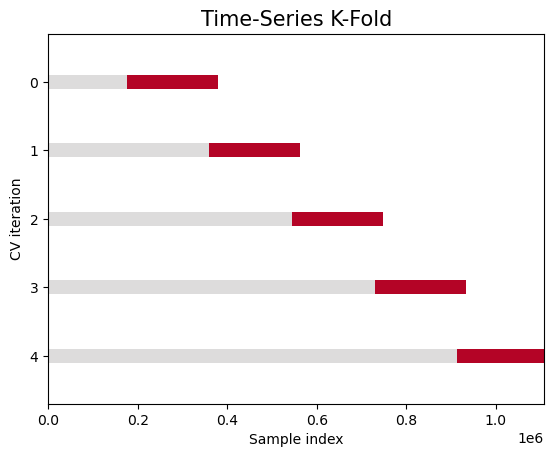

In [51]:
# TimeSeriesSplit를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=Y_train,
                cv=kf,
                ax=ax,
                split_strategy='Time-Series K-Fold')

In [60]:
# 학습 데이터를 TimeSeriesSplit로 나눕니다.
train_folds = kf.split(X_train, Y_train)
display(train_folds)

<generator object TimeSeriesSplit.split at 0x0000022D90D20BC0>

In [50]:
# Y_train # 1062880

In [51]:
# Y_test # 55942

In [52]:
# # 학습을 진행합니다.
# %%time
# fold_save_files = []

# for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
#     display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

#     # index를 통해 fold의 학습세트를 가져옵니다.
#     X_train_fold = X_train.iloc[train_idx, :]
#     Y_train_fold = Y_train[train_idx]

#     # index를 통해 fold의 평가세트를 가져옵니다.
#     X_valid_fold = X_train.iloc[valid_idx, :]
#     Y_valid_fold = Y_train[valid_idx]

#     # fold의 데이터로 학습을 진행합니다.
#     gbm = lgb.LGBMRegressor(n_estimators=1000)
#     gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
#         eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
#         eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
#         callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
#                    lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
#     )

#     # 각 fold별 학습한 모델을 저장합니다.
#     file_name = f"timeseries_fold{fold_idx}_gbm.pkl"
#     joblib.dump(gbm, file_name)
#     display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
#     fold_save_files.append(file_name)


#### LGBM Regressor

In [53]:
# 원본코드
import time
from datetime import datetime

# 시작 시간 기록
start_time = time.time()  # 또는 datetime.now()

# 학습을 진행하는 코드
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,
            eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=10),
                       lgb.log_evaluation(period=10, show_stdv=True)]
            )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"timeseries_fold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    print(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)
    
# 종료 시간 기록
end_time = time.time()  # 또는 datetime.now()
elapsed_time = end_time - start_time
print(f"전체 코드 실행 시간: {elapsed_time} 초")  # 또는 print(f"전체 코드 실행 시간: {elapsed_time}")



--------0번째 fold의 학습을 시작합니다.--------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7243
[LightGBM] [Info] Number of data points in the train set: 177150, number of used features: 44
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 40795.590291
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 15642.4	training's l2: 2.44684e+08	valid_1's rmse: 17362.5	valid_1's l2: 3.01455e+08
[20]	training's rmse: 10990.5	training's l2: 1.2079e+08	valid_1's rmse: 13068.5	valid_1's l2: 1.70786e+08
[30]	training's rmse: 9275.31	training's l2: 8.60313e+07	valid_1's rmse: 11763	valid_1's l2: 1.38368e+08
[40]	training's rmse: 8397.31	training's l2: 7.05147e+07	valid_1's rmse: 1126

In [54]:
fold_save_files

['timeseries_fold0_gbm.pkl',
 'timeseries_fold1_gbm.pkl',
 'timeseries_fold2_gbm.pkl',
 'timeseries_fold3_gbm.pkl',
 'timeseries_fold4_gbm.pkl']

In [55]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = MSE(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = MSE(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'timeseries_fold0_gbm.pkl - Test rmse : 76108.40226201976'

'timeseries_fold1_gbm.pkl - Test rmse : 80433.19714011175'

'timeseries_fold2_gbm.pkl - Test rmse : 75414.68249086663'

'timeseries_fold3_gbm.pkl - Test rmse : 67116.85436881907'

'timeseries_fold4_gbm.pkl - Test rmse : 43876.0985322577'

'최종 Test rmse : 68063.66231577678'

In [56]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["timeseries_fold0_gbm.pkl", "timeseries_fold2_gbm.pkl", "timeseries_fold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = MSE(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = MSE(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'timeseries_fold0_gbm.pkl - Test rmse : 76108.40226201976'

'timeseries_fold2_gbm.pkl - Test rmse : 75414.68249086663'

'timeseries_fold4_gbm.pkl - Test rmse : 43876.0985322577'

'최종 Test rmse : 64407.740333478134'

## 여기!!!!!

In [57]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files: # top_3_files로 하면 점수 더 나아지지 않나?
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = MSE(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = MSE(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'timeseries_fold0_gbm.pkl - Test rmse : 76108.40226201976'

'timeseries_fold1_gbm.pkl - Test rmse : 80433.19714011175'

'timeseries_fold2_gbm.pkl - Test rmse : 75414.68249086663'

'timeseries_fold3_gbm.pkl - Test rmse : 67116.85436881907'

'timeseries_fold4_gbm.pkl - Test rmse : 43876.0985322577'

'최종 Test rmse : 68063.66231577678'

In [58]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["timeseries_fold2_gbm.pkl", "timeseries_fold3_gbm.pkl", "timeseries_fold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = MSE(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = MSE(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'timeseries_fold2_gbm.pkl - Test rmse : 75414.68249086663'

'timeseries_fold3_gbm.pkl - Test rmse : 67116.85436881907'

'timeseries_fold4_gbm.pkl - Test rmse : 43876.0985322577'

'최종 Test rmse : 61575.36893580113'

In [ ]:
# 저장한 학습모델들의 파일 이름 리스트
# fold_save_files

# # 저장한 학습모델들을 불러옵니다.
# models = []
# for file_name in fold_save_files:
#     model = joblib.load(file_name)
#     models.append(model)

# # 예측하려는 새로운 데이터 (X_new)를 준비합니다. 이 예시에서는 임의로 생성합니다.
# X_new = np.random.rand(10, 5)  # 예시 데이터: 10개의 데이터 포인트, 각각 5개의 특성을 가짐

# # 각 모델로부터 예측을 수행합니다.
# predictions = []
# for model in models:
#     predictions.append(model.predict(X_sub))

# # 각 모델의 예측값을 평균하여 최종 예측값을 구합니다.
# final_predictions = np.mean(predictions, axis=0)

# # 최종 예측값 출력
# print("최종 예측값:", final_predictions)

최종 예측값: [ 95089.00215151 143717.92835734 161339.14226555 ...  55315.48261131
  45811.03162393  44961.47202609]


In [59]:
# 저장한 학습모델들을 불러옵니다.
models = []
for file_name in fold_save_files:
    model = joblib.load(file_name)
    models.append(model)

# 여러 모델을 하나의 파일로 저장합니다.
joblib.dump(models, 'combined_models.pkl')

['combined_models.pkl']

In [74]:
# 저장된 모델 파일을 불러옵니다.
models = joblib.load('combined_models.pkl')

# 각 모델로부터 예측을 수행합니다.
predictions = []
for model in models:
    predictions.append(model.predict(X_sub))

# 각 모델의 예측값을 평균하여 최종 예측값을 구합니다.
final_predictions = np.mean(predictions, axis=0)

# 최종 예측값 출력
print("최종 예측값:", final_predictions)


KeyboardInterrupt: 

In [67]:
result = pd.DataFrame(final_predictions)
result.columns = ['target']
result = result['target'].astype('int')
result.to_csv('ts_L_1.csv', index=False)

In [237]:
# sub_pred = pd.DataFrame(final_predictions)# 

In [238]:
# Y_sub = pd.DataFrame(Y_sub)

In [243]:
# def fin_score(y_true, y_pred):
#     R2_Score = r2_score(y_true, y_pred)
#     RMSE = MSE(y_true, y_pred) ** 2

#     return f'R2_Score : {R2_Score} / RMSE : {RMSE}'

In [244]:
# fin_score(Y_sub, sub_pred)

'R2_Score : 0.9070158525326232 / RMSE : 3.853663257704908e+17'

#### RandomForestRegressor

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
import numpy as np
import time

# 시작 시간 기록
start_time = time.time()

# 학습을 진행하는 코드
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    rf = RandomForestRegressor(n_estimators=100, random_state=42)  # RandomForestRegressor 설정
    rf.fit(X_train_fold, Y_train_fold)

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"timeseries_fold{fold_idx}_rf.pkl"
    joblib.dump(rf, file_name)
    print(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)

# 종료 시간 기록
end_time = time.time()
elapsed_time = end_time - start_time
print(f"전체 코드 실행 시간: {elapsed_time} 초")

--------0번째 fold의 학습을 시작합니다.--------
--------0번째 fold는 timeseries_fold0_rf.pkl에 저장되었습니다.--------


--------1번째 fold의 학습을 시작합니다.--------
--------1번째 fold는 timeseries_fold1_rf.pkl에 저장되었습니다.--------


--------2번째 fold의 학습을 시작합니다.--------
--------2번째 fold는 timeseries_fold2_rf.pkl에 저장되었습니다.--------


--------3번째 fold의 학습을 시작합니다.--------
--------3번째 fold는 timeseries_fold3_rf.pkl에 저장되었습니다.--------


--------4번째 fold의 학습을 시작합니다.--------
--------4번째 fold는 timeseries_fold4_rf.pkl에 저장되었습니다.--------


--------5번째 fold의 학습을 시작합니다.--------
--------5번째 fold는 timeseries_fold5_rf.pkl에 저장되었습니다.--------


--------6번째 fold의 학습을 시작합니다.--------
--------6번째 fold는 timeseries_fold6_rf.pkl에 저장되었습니다.--------


--------7번째 fold의 학습을 시작합니다.--------
--------7번째 fold는 timeseries_fold7_rf.pkl에 저장되었습니다.--------


--------8번째 fold의 학습을 시작합니다.--------
--------8번째 fold는 timeseries_fold8_rf.pkl에 저장되었습니다.--------


--------9번째 fold의 학습을 시작합니다.--------
--------9번째 fold는 timeseries_fold9_rf.pkl에 저장되었습니다.--------


전체 코드 실행 시

In [61]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    rf_trained = joblib.load(file_name)
    fold_predicts = rf_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = MSE(Y_test, fold_predicts)**0.5
    print(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = MSE(Y_test, total_predicts)**0.5
print(f"최종 Test rmse : {RMSE}")



timeseries_fold0_rf.pkl - Test rmse : 74873.98523132328
timeseries_fold1_rf.pkl - Test rmse : 72709.1527682042
timeseries_fold2_rf.pkl - Test rmse : 75905.64467032989
timeseries_fold3_rf.pkl - Test rmse : 79003.34764336357
timeseries_fold4_rf.pkl - Test rmse : 75742.32686589278
timeseries_fold5_rf.pkl - Test rmse : 71726.94892437293
timeseries_fold6_rf.pkl - Test rmse : 66141.86183692275
timeseries_fold7_rf.pkl - Test rmse : 57372.260323632494
timeseries_fold8_rf.pkl - Test rmse : 41393.6001388334
timeseries_fold9_rf.pkl - Test rmse : 27114.153990628853
최종 Test rmse : 63263.07411436765


### 여기는 수기로 지정하기!!

In [56]:
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib

# 위 학습 로그에서 검증세트를 기준으로 RMSE가 가장 낮은 3개의 모델을 선택합니다.
top_3_files = ["timeseries_fold0_rf.pkl", "timeseries_fold2_rf.pkl", "timeseries_fold4_rf.pkl"]  # 수기로 지정할 부분/

# Test 데이터에 대한 예측값을 저장할 배열을 초기화합니다.
total_predicts = np.zeros(len(X_test))

# 각 모델 파일에 대해 예측을 수행하고, 평균 예측값을 계산합니다.
for file_name in top_3_files:
    # 모델 파일을 불러옵니다.
    rf_trained = joblib.load(file_name)
    
    # Test 데이터에 대한 예측값을 계산합니다.
    fold_predicts = rf_trained.predict(X_test)
    
    # 각 fold의 RMSE를 계산합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    print(f"{file_name} - Test RMSE: {RMSE}")
    
    # 전체 예측값에 현재 fold의 예측값을 더합니다. (평균 계산을 위해)
    total_predicts += fold_predicts / len(top_3_files)

# 최종 Test RMSE를 계산합니다.
final_RMSE = mean_squared_error(Y_test, total_predicts)**0.5
print(f"최종 Test RMSE: {final_RMSE}")


timeseries_fold0_rf.pkl - Test RMSE: 78308.77611131807
timeseries_fold2_rf.pkl - Test RMSE: 78442.73649404601
timeseries_fold4_rf.pkl - Test RMSE: 77900.58772862573
최종 Test RMSE: 77942.16850859244


In [58]:
# 개별모델 모델 저장 후 커널 꺼지거나 메모리 오류나면 사용하기

fold_save_files = []

for i in range(10):
    fold_save_files.append(f'timeseries_fold{i}_rf.pkl')


In [59]:
fold_save_files

['timeseries_fold0_rf.pkl',
 'timeseries_fold1_rf.pkl',
 'timeseries_fold2_rf.pkl',
 'timeseries_fold3_rf.pkl',
 'timeseries_fold4_rf.pkl',
 'timeseries_fold5_rf.pkl',
 'timeseries_fold6_rf.pkl',
 'timeseries_fold7_rf.pkl',
 'timeseries_fold8_rf.pkl',
 'timeseries_fold9_rf.pkl']

In [60]:
# 저장한 학습모델들을 불러옵니다.
models = []
for file_name in fold_save_files:
    model = joblib.load(file_name)
    models.append(model)

# 여러 모델을 하나의 파일로 저장합니다.
joblib.dump(models, 'combined_models.pkl')

['combined_models.pkl']

In [75]:
# 저장된 모델 파일을 불러옵니다.
models = joblib.load('combined_models.pkl')

# 각 모델로부터 예측을 수행합니다.
predictions = []
for model in models:
    predictions.append(model.predict(X_sub))

# 각 모델의 예측값을 평균하여 최종 예측값을 구합니다.
final_predictions = np.mean(predictions, axis=0)

# 최종 예측값 출력
print("최종 예측값:", final_predictions)


In [ ]:
result = pd.DataFrame(final_predictions)
result.columns = ['target']
result = result['target'].astype('int')
result.to_csv('ts_L_1.csv', index=False)